## Imports

In [1]:
import scipy.io, random
import numpy as np
from utils import *
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Forecasting

In [2]:
def plot_forecast(source, prediction, nrow=5, ncol=5, from_=2800, to_=None):
    n = source.shape[0]
    idx = random.sample(range(n), nrow * ncol)
    fig, axs = plt.subplots(nrow, ncol, figsize=(15,8), sharex=True)
    if to_ is None:
        to_ = source.shape[1]
    i = 0
    for r in range(nrow):
        for c in range(ncol):
            axs[r,c].plot(prediction[idx[i], from_:to_], c='r')
            axs[r,c].plot(source[idx[i], from_:to_], c='b')

            i += 1
    fig.tight_layout()
    plt.show()

In [3]:
def plot_shape_function(d, F1, F2, nrow=5, ncol=5):
    n = F1.shape[1]
    idx = random.sample(range(n), nrow * ncol)
    fig, axs = plt.subplots(nrow, ncol, figsize=(15,8), sharex=True)
    i = 0
    for r in range(nrow):
        for c in range(ncol):
            if F2 is not None:
                axs[r,c].scatter(d, F1[:, idx[i]], c='b')
                axs[r,c].scatter(d, F2[:, idx[i]], c='r')
            else:
                axs[r,c].scatter(d, F1[:, idx[i]])
            i += 1
    fig.tight_layout()
    plt.show()

In [ ]:
# Colors
# size = out[2].shape[1]
# colors = list(mcolors.CSS4_COLORS.keys())
# indices = random.choices(range(len(colors)), k=size)

In [4]:
def scale_distance(d, range=[0,1]):
    if range is None:
        return d
    from sklearn.preprocessing import MinMaxScaler
    d = d.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=range)
    norm_d = scaler.fit_transform(d)
    return norm_d

## Learning

In [5]:
sim = load_pickle('output/sim.pickle')

In [6]:
sim[2] = sim[2].detach().numpy()
sim[0].shape, sim[1].shape, sim[2].shape

((30, 100), (30, 100), (900, 1))

In [ ]:
sim[0]

In [ ]:
T = sim[0].shape[1]

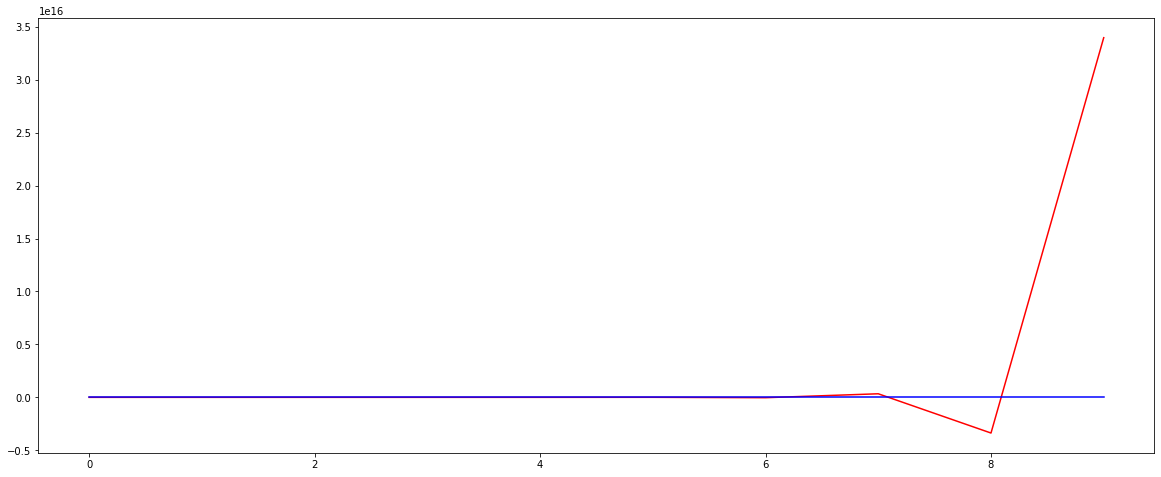

In [24]:
f, t = 90, 100
plt.figure(figsize=(20,8))
plt.plot(sim[1][10, f:t], c='r')
plt.plot(sim[0][10, f:t], c='b')

plt.show()

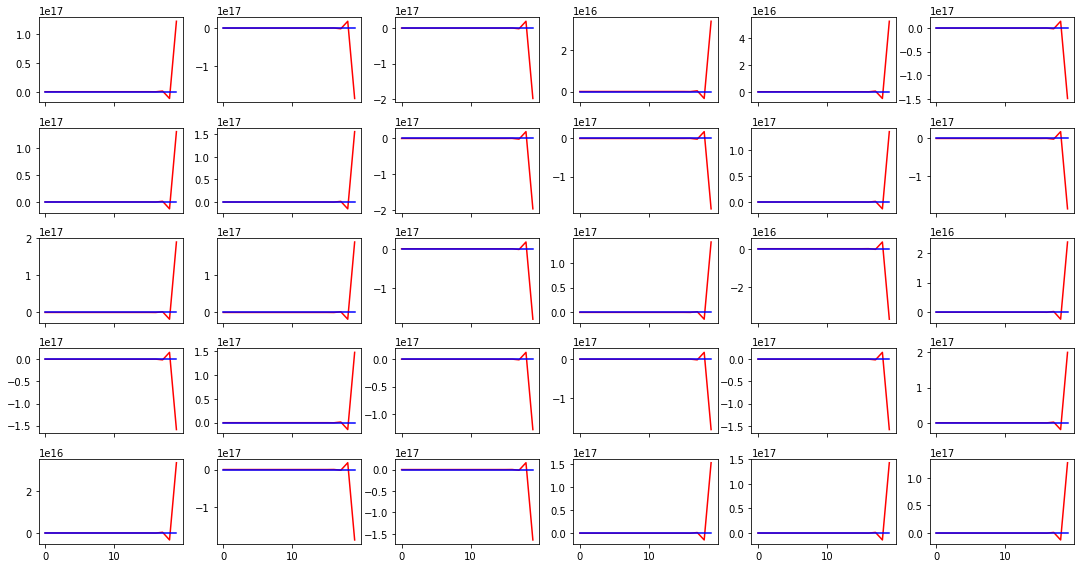

In [22]:
plot_forecast(sim[0], sim[1], 5, 6, 80, 100)

## Simulation

In [13]:
_, d, _ = load_pickle('data/sample_small.pickle')

In [16]:
norm_d = scale_distance(d, None)
norm_d = norm_d.reshape(-1, 1)

In [20]:
F =  1e-2 * np.log(norm_d+1)

In [ ]:
d[:10], sim[2][:10], F[:10]

In [ ]:
F.shape, sim[2].shape

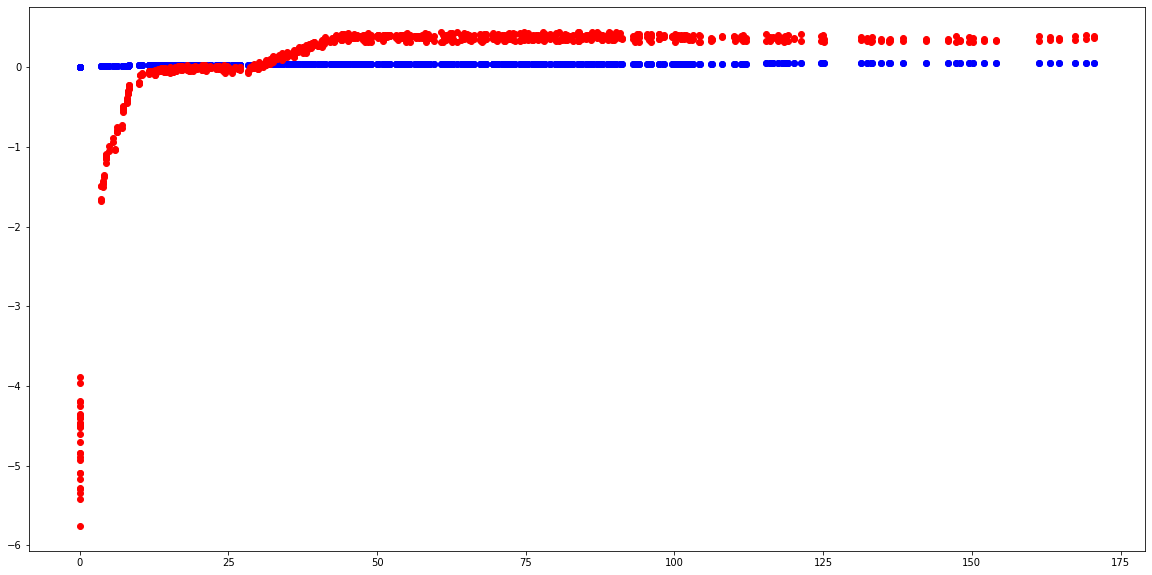

In [21]:
l = 0
plt.figure(figsize=(20,10))
plt.scatter(d, F[:, l], c='b')
plt.scatter(d, sim[2][:, l], c='r')

In [ ]:
plot_shape_function(d, F, sim[2], 5, 5)

## Weight dynamics

In [ ]:
def plot_weights(f, N, name):
    fd = f.reshape((N, N))
    fd = np.exp(-fd)
    plt.figure(figsize=(8, 8))
    plt.imshow(fd, cmap="YlGn")
    plt.title(name)
    cax = plt.axes([0.85, 0.1, 0.075, 0.8])
    plt.colorbar(cax=cax)
    plt.savefig(f'viz/weight/{name}.png')

In [ ]:
F = np.load('data/estimates.npy')
NN, T = F.shape
N = np.sqrt(NN).astype('int')

In [ ]:
for t in range(0, T, 200):
    f = F[:, t]
    plot_weights(f, N, f"T{t}")